# Denoising Autoencoder with PyTorch

This notebook demonstrates how to build and train a simple denoising autoencoder using PyTorch. A denoising autoencoder is a type of neural network that learns to reconstruct clean input data from corrupted or noisy input.

The notebook covers the following steps:

1.  **Import necessary libraries**: Import PyTorch, torchvision, and matplotlib.
2.  **Load and prepare data**: Load the MNIST dataset and create a DataLoader.
3.  **Define noise function**: Create a function to add Gaussian noise to images.
4.  **Define the Denoising Autoencoder model**: Build a simple autoencoder with an encoder and decoder using fully connected layers.
5.  **Set up training components**: Define the device, model instance, loss function (MSE), and optimizer (Adam).
6.  **Train the model**: Implement the training loop, adding noise to the input images and training the autoencoder to reconstruct the original images.
7.  **Visualize results**: Show examples of original, noisy, and denoised images to evaluate the model's performance.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# Data loader
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.12MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.19MB/s]


In [3]:
# Add Gaussian noise to images
def add_noise(imgs, noise_factor=0.5):
    noisy_imgs = imgs + noise_factor * torch.randn_like(imgs)
    return torch.clamp(noisy_imgs, 0.0, 1.0)

In [4]:
class DenoisingAutoencoder(nn.Module):
    """
    A simple denoising autoencoder implemented using PyTorch.

    This autoencoder is designed to take noisy images as input and
    reconstruct the original, clean images. It consists of a symmetrical
    encoder and decoder structure with fully connected layers and ReLU
    activation functions, except for the final output layer which uses
    a Sigmoid to ensure the output is in the range [0, 1].

    The input images are expected to be flattened into a 1D tensor
    representing 28x28 pixels.

    Attributes:
        enc (nn.Sequential): The encoder part of the autoencoder.
                             It consists of three linear layers with ReLU
                             activations, reducing the dimensionality from
                             784 to 256, then to 64, and finally to 16.
        dec (nn.Sequential): The decoder part of the autoencoder.
                             It consists of three linear layers, mirroring
                             the encoder in reverse. It increases the
                             dimensionality from 16 to 64, then to 256,
                             and finally to 784, followed by a Sigmoid
                             activation.
    """
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
        )
        # Decoder
        self.dec = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid(), # To keep output in [0, 1]
        )

    def forward(self, x):
        """
        Defines the forward pass of the denoising autoencoder.

        Args:
            x (torch.Tensor): The input tensor containing flattened images.
                              Expected shape is (batch_size, 28 * 28).

        Returns:
            torch.Tensor: The reconstructed output tensor, with the same shape
                          as the input (batch_size, 28 * 28), but representing
                          the denoised images. The values are in the range [0, 1].
        """
        x = x.view(-1, 28 * 28)     # Flatten images
        encoded = self.enc(x)
        decoded = self.dec(encoded)
        return decoded

In [5]:
# Model, optimizer, loss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DenoisingAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [6]:
# Training loop
for epoch in range(20):  # 20 epochs for quick demo
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        noisy_imgs = add_noise(imgs, noise_factor=0.5).to(device)
        # Forward
        outputs = model(noisy_imgs)
        loss = criterion(outputs, imgs.view(-1, 28 * 28))
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}: loss={loss.item():.4f}')

Epoch 1: loss=0.0504
Epoch 2: loss=0.0368
Epoch 3: loss=0.0338
Epoch 4: loss=0.0274
Epoch 5: loss=0.0256
Epoch 6: loss=0.0264
Epoch 7: loss=0.0244
Epoch 8: loss=0.0252
Epoch 9: loss=0.0235
Epoch 10: loss=0.0205
Epoch 11: loss=0.0236
Epoch 12: loss=0.0223
Epoch 13: loss=0.0219
Epoch 14: loss=0.0210
Epoch 15: loss=0.0201
Epoch 16: loss=0.0197
Epoch 17: loss=0.0208
Epoch 18: loss=0.0195
Epoch 19: loss=0.0189
Epoch 20: loss=0.0191


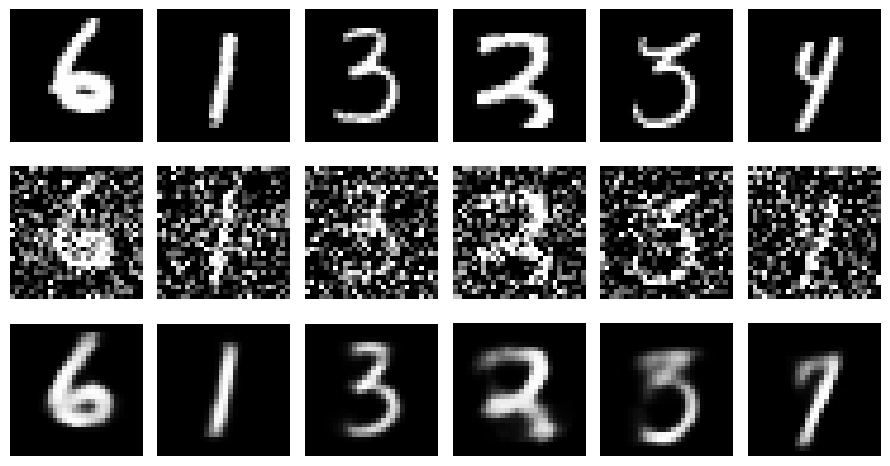

In [9]:
# Test denoising and visualize
def plot_images(original, noisy, denoised, n=6):
    """Plots original, noisy, and denoised images."""
    plt.figure(figsize=(9, 5))
    for i in range(n):
        plt.subplot(3, n, i + 1)
        plt.imshow(original[i].squeeze(0), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.ylabel('Original')

        plt.subplot(3, n, i + 1 + n)
        plt.imshow(noisy[i].squeeze(0), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.ylabel('Noisy')

        plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(denoised[i].view(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.ylabel('Denoised')
    plt.tight_layout()
    plt.show()

imgs, _ = next(iter(train_loader))
noisy_imgs = add_noise(imgs, noise_factor=0.5)
outputs = model(noisy_imgs.to(device)).cpu().detach()

plot_images(imgs, noisy_imgs, outputs)